# Lab4-Assignment about Named Entity Recognition and Classification

This notebook describes the assignment of Lab 4 of the text mining course. We assume you have succesfully completed Lab1, Lab2 and Lab3 as welll. Especially Lab2 is important for completing this assignment.

**Learning goals**
* going from linguistic input format to representing it in a feature space
* working with pretrained word embeddings
* train a supervised classifier (SVM)
* evaluate a supervised classifier (SVM)
* learn how to interpret the system output and the evaluation results
* be able to propose future improvements based on the observed results


## Credits
This notebook was originally created by [Marten Postma](https://martenpostma.github.io) and [Filip Ilievski](http://ilievski.nl) and adapted by Piek vossen

## [Points: 18] Exercise 1 (NERC): Training and evaluating an SVM using CoNLL-2003

**[4 point] a) Load the CoNLL-2003 training data using the *ConllCorpusReader* and create for both *train.txt* and *test.txt*:**

    [2 points]  -a list of dictionaries representing the features for each training instances, e..g,
    ```
    [
    {'words': 'EU', 'pos': 'NNP'}, 
    {'words': 'rejects', 'pos': 'VBZ'},
    ...
    ]
    ```

    [2 points] -the NERC labels associated with each training instance, e.g.,
    dictionaries, e.g.,
    ```
    [
    'B-ORG', 
    'O',
    ....
    ]
    ```

In [10]:
from os.path import abspath
from typing import List, Dict
from nltk.corpus.reader import ConllCorpusReader
import numpy as np
from numpy import ndarray
### Adapt the path to point to the CONLL2003 folder on your local machine

# load everything in:
# ---------------------------
path = abspath("CONLL2003")
train = ConllCorpusReader(path, 'train.txt', ['words', 'pos', 'ignore', 'chunk'])
test = ConllCorpusReader(path, 'test.txt', ['words', 'pos', 'ignore', 'chunk'])
# ///////////////////////////


# create the lists:
# ---------------------------
train_dict_list : List[Dict[str, str]] = []
test_dict_list  : List[Dict[str, str]] = []

train_labels: List[str] = []
test_labels: List[str] = []
# ///////////////////////////


# get the data
# ---------------------------
for token, pos, ne_label in train.iob_words():
    train_dict_list.append({"words": token, "pos": pos})
    train_labels.append(ne_label)

for token, pos, ne_label in test.iob_words():
    test_dict_list.append({"words": token, "pos": pos})
    test_labels.append(ne_label)
# ///////////////////////////



**[2 points] b) provide descriptive statistics about the training and test data:**
* How many instances are in train and test?
* Provide a frequency distribution of the NERC labels, i.e., how many times does each NERC label occur?
* Discuss to what extent the training and test data is balanced (equal amount of instances for each NERC label) and to what extent the training and test data differ?

Tip: you can use the following `Counter` functionality to generate frequency list of a list:

In [11]:
n_train: int = len(train_dict_list)
n_test: int = len(test_dict_list)
share_train: float = round(n_train/(n_train+n_test)*100)
share_test: float = 100 - share_train

print(f"amount of training instances: {n_train}")
print(f"amount of testing instances: {n_test}")
print("--"*30)
print(f"This means that {share_train}% of the data is for training.")
print(f"And {share_test}% of the data is for testing")


amount of training instances: 203621
amount of testing instances: 46435
------------------------------------------------------------
This means that 81% of the data is for training.
And 19% of the data is for testing


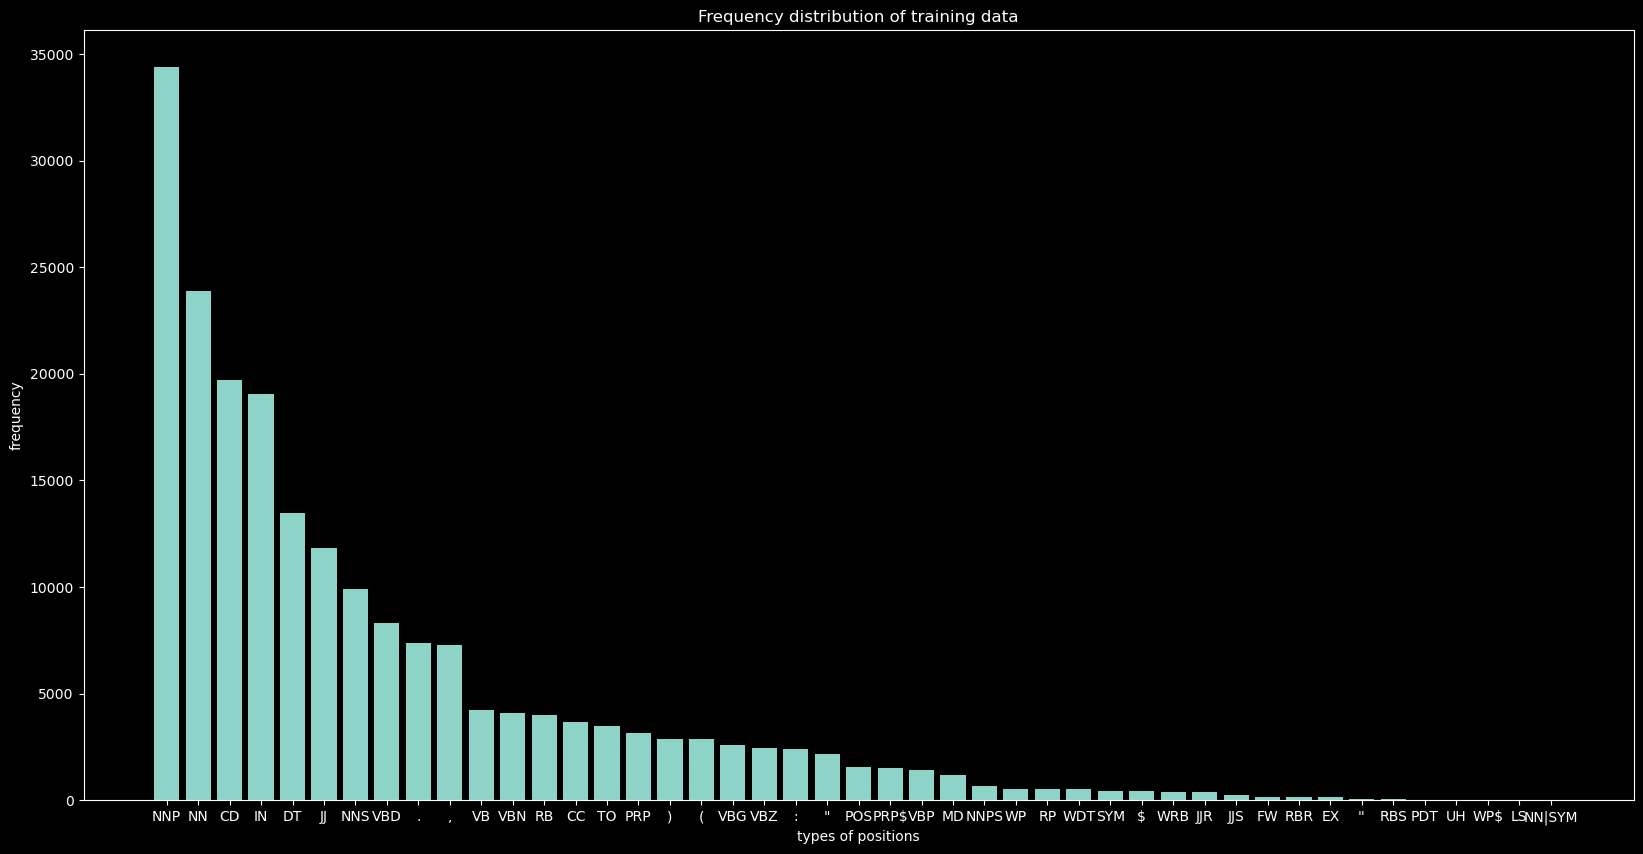

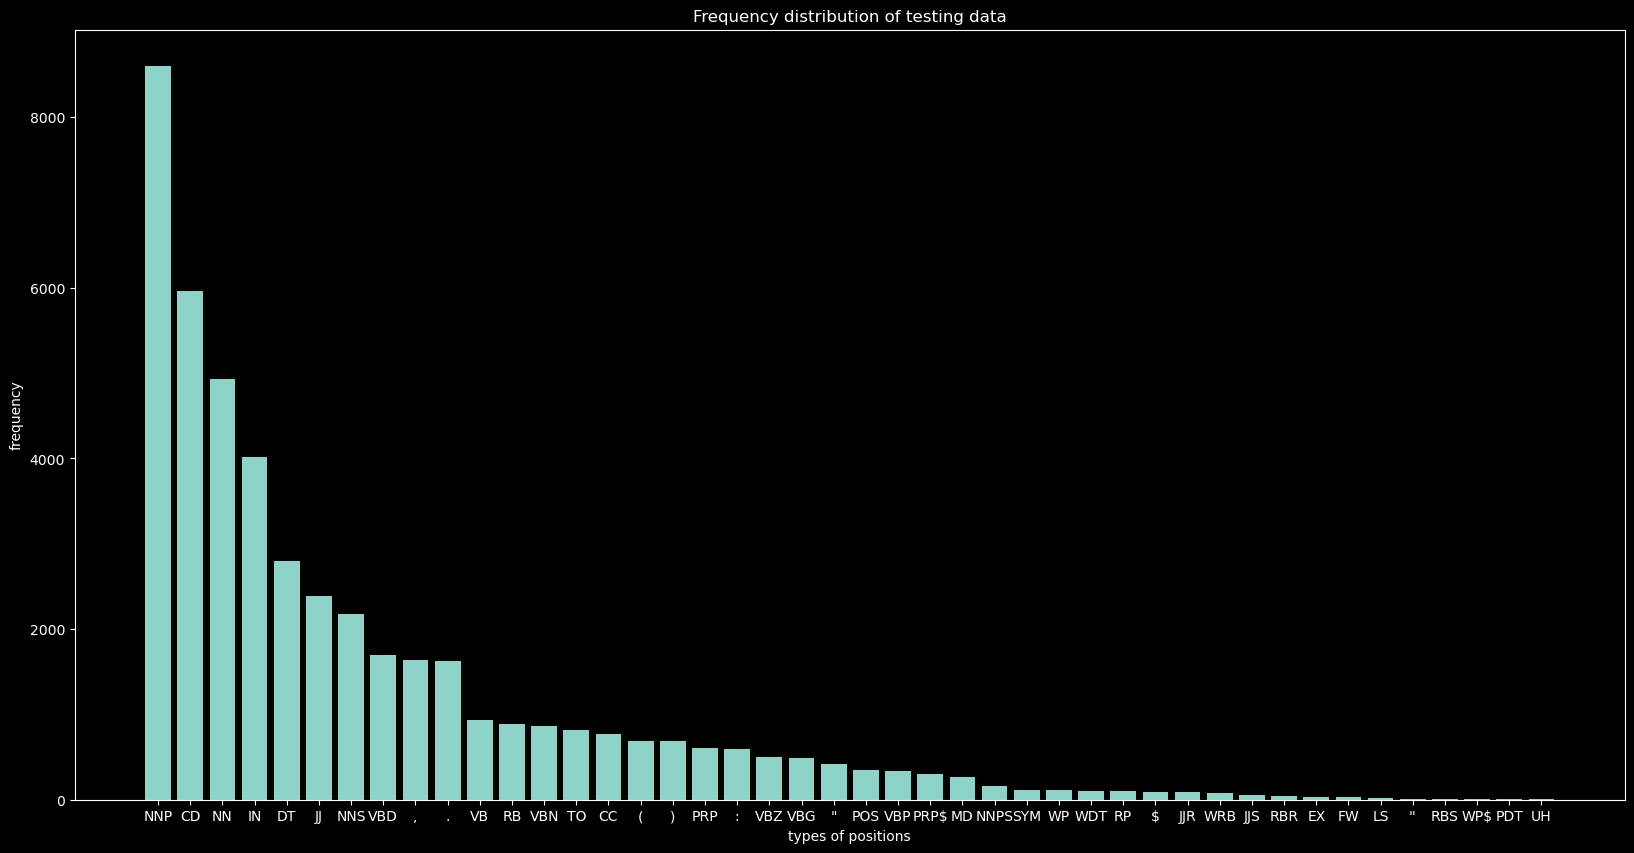

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

def get_dist_plot(data: List[dict], title: str, x_label: str, y_label: str) -> None:
    """Generates """
    positions: List[str] = []
    for instance in data:
        positions.append(instance["pos"])
    pos_count = Counter(positions)

    bins: List[str] = list(pos_count.keys())
    values_for_bin: List[int] = list(pos_count.values())

    ordered_indices = np.argsort(values_for_bin)
    ordered_bins: List[str] = []
    ordered_frequencies: List[str] = []
    for idx in ordered_indices[::-1]:
        ordered_bins.append(bins[idx])
        ordered_frequencies.append(values_for_bin[idx])


    plt.figure(figsize=(20, 10))
    plt.bar(ordered_bins, ordered_frequencies)

    plt.title(label=title)
    plt.xlabel(xlabel=x_label)
    plt.ylabel(ylabel=y_label)

    return None

get_dist_plot(train_dict_list, "Frequency distribution of training data", "types of positions", "frequency")
get_dist_plot(test_dict_list, "Frequency distribution of testing data", "types of positions", "frequency")


### Analysis of training and test data

When looking at the charts and numbers describing the training and test data, it is obvious to say that the data is not balanced. Out of all the types, NNP reigns supreme across both the training and test data. The distribtion of the data looks like the distribution given by Zipf's law, which states that words and their frequency are related with the formula:  $\text{f(n)} = \frac{1}{\text{word rank}}$. The highest ranking words are incredibly dominant in the distribution, whilst the large majority of word positions hardly make a dent at all.

**[2 points] c) Concatenate the train and test features (the list of dictionaries) into one list. Load it using the *DictVectorizer*. Afterwards, split it back to training and test.**

Tip: You’ve concatenated train and test into one list and then you’ve applied the DictVectorizer.
The order of the rows is maintained. You can hence use an index (number of training instances) to split the_array back into train and test. Do NOT use: `
from sklearn.model_selection import train_test_split` here.


In [13]:
total = train_dict_list.copy()
total.extend(test_dict_list)
print(len(total))

250056


In [14]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=True)
vectorized_data = vec.fit_transform(total)



In [15]:
vectorized_test_data        : List[ndarray] = []
vectorized_training_data    : List[ndarray] = []

for idx, row in enumerate(vectorized_data):
    if idx < 203621:
        vectorized_training_data.append(row)
        continue
    vectorized_test_data.append(row)

    
print(len(vectorized_training_data))
print(len(vectorized_test_data))




203621
46435


**[4 points] d) Train the SVM using the train features and labels and evaluate on the test data. Provide a classification report (sklearn.metrics.classification_report).**
The train (*lin_clf.fit*) might take a while. On my computer, it took 1min 53s, which is acceptable. Training models normally takes much longer. If it takes more than 5 minutes, you can use a subset for training. Describe the results:
* Which NERC labels does the classifier perform well on? Why do you think this is the case?
* Which NERC labels does the classifier perform poorly on? Why do you think this is the case?

In [16]:
from sklearn import svm

In [17]:
lin_clf = svm.LinearSVC()

In [18]:
from sklearn.svm import LinearSVC
from scipy.sparse import csr_matrix
import numpy as np

# Assuming X_train is a list of sparse matrices, convert it to a single sparse matrix if needed
from scipy.sparse import vstack

In [19]:
##### [ YOUR CODE SHOULD GO HERE ]
lin_clf.fit(vstack(vectorized_training_data), train_labels) # your code here

c:\Users\dexter\AppData\Local\Programs\Anaconda\envs\TM\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [20]:
predictions : ndarray[str] = lin_clf.predict(vstack(vectorized_test_data))

In [21]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

       B-LOC       0.81      0.77      0.79      1668
      B-MISC       0.78      0.66      0.71       702
       B-ORG       0.79      0.52      0.62      1661
       B-PER       0.86      0.44      0.58      1617
       I-LOC       0.62      0.53      0.57       257
      I-MISC       0.59      0.59      0.59       216
       I-ORG       0.66      0.48      0.55       835
       I-PER       0.33      0.87      0.48      1156
           O       0.99      0.98      0.98     38323

    accuracy                           0.92     46435
   macro avg       0.71      0.65      0.65     46435
weighted avg       0.94      0.92      0.92     46435



### Answer:
* The classifier performs well on the NERC labels B-PER and B-LOC. This is probably because they remain consistent across the training and test data and also recognizable in real-life context.
* The classifier performs poorly on the NERC labels I-MISC and I-PER. This is probably because they have a lot of variants in real-life and insufficient training data to be recognized by the classifier.

**[6 points] e) Train a model that uses the embeddings of these words as inputs. Test again on the same data as in 2d. Generate a classification report and compare the results with the classifier you built in 2d.**

In [22]:
import gensim
#Adapt the path to point to your local copy of the Google embeddings model
#word_embedding_model = gensim.models.KeyedVectors.load_word2vec_format('path/to/GoogleNews-vectors-negative300.bin', binary=True)  
word_embedding_model = gensim.models.KeyedVectors.load_word2vec_format(r"C:\Users\dexter\Documents\VU_UvA\TMAI\ba-text-mining\lab_sessions\lab4\GoogleNews-vectors-negative300.bin.gz", binary = True)



In [23]:
def get_embeddings(data: Dict[str, str]) -> List[ndarray]:
    word_embeddings: List[ndarray] = []

    for training_instance in data:
        word        : str       = training_instance["words"]

        try:
            embedding   : ndarray   = word_embedding_model[word]
        except KeyError:
            embedding   : ndarray   = np.zeros(300)

        word_embeddings.append(embedding)
    
    return word_embeddings

training_embeddings = get_embeddings(train_dict_list)
test_embeddings = get_embeddings(test_dict_list)

print(len(training_embeddings), len(train_labels))
print(len(test_embeddings), len(test_labels))



203621 203621
46435 46435


In [24]:
embedding_svm = LinearSVC()
embedding_svm.fit(training_embeddings, train_labels)

LinearSVC()

In [25]:
embedding_predictions = embedding_svm.predict(test_embeddings)
print(classification_report(test_labels, embedding_predictions))

              precision    recall  f1-score   support

       B-LOC       0.76      0.80      0.78      1668
      B-MISC       0.72      0.70      0.71       702
       B-ORG       0.69      0.64      0.66      1661
       B-PER       0.75      0.67      0.71      1617
       I-LOC       0.51      0.42      0.46       257
      I-MISC       0.60      0.54      0.57       216
       I-ORG       0.48      0.33      0.39       835
       I-PER       0.59      0.50      0.54      1156
           O       0.97      0.99      0.98     38323

    accuracy                           0.93     46435
   macro avg       0.68      0.62      0.64     46435
weighted avg       0.92      0.93      0.92     46435



## [Points: 10] Exercise 2 (NERC): feature inspection using the [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)
**[6 points] a. Perform the same steps as in the previous exercise. Make sure you end up for both the training part (*df_train*) and the test part (*df_test*) with:**
* the features representation using **DictVectorizer**
* the NERC labels in a list

Please note that this is the same setup as in the previous exercise:
* load both train and test using:
    * list of dictionaries for features
    * list of NERC labels
* combine train and test features in a list and represent them using one hot encoding
* train using the training features and NERC labels

In [26]:
import pandas

In [31]:
##### Adapt the path to point to your local copy of NERC_datasets
path = r'C:\Users\dexter\Documents\VU_UvA\TMAI\ba-text-mining\lab_sessions\lab4\ner_v2.csv'
kaggle_dataset = pandas.read_csv(path, on_bad_lines='skip')
kaggle_dataset = kaggle_dataset.dropna()

In [32]:
len(kaggle_dataset)

1050761

In [33]:
df_train = kaggle_dataset[:100000]
df_test = kaggle_dataset[100000:120000]
print(len(df_train), len(df_test))

100000 20000


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer

feature_list = []
ner_label = []

for _, entry in kaggle_dataset.iterrows():
    #print(entry)
    entry_word = entry['word']
    entry_pos = entry['pos']
    feature_list.append({'Words': entry_word, 'POS': entry_pos})
    ner_label.append(entry['tag'])

train_features, test_features, train_tags, test_tags = train_test_split(feature_list, ner_label, test_size=0.2, random_state=42)

all_features = train_features + test_features
vectorizer = DictVectorizer()
encoded_features = vectorizer.fit_transform(all_features)

X_train = encoded_features[:len(train_features)]
X_test = encoded_features[len(train_features):]
y_train = train_tags
y_test = test_tags

svm_classifier = LinearSVC()
svm_classifier.fit(X_train, y_train)

predictions = svm_classifier.predict(X_test)
print(classification_report(y_test, predictions))

c:\Users\dexter\AppData\Local\Programs\Anaconda\envs\TM\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

       B-art       0.51      0.27      0.36        88
       B-eve       0.68      0.38      0.49        60
       B-geo       0.78      0.88      0.82      7483
       B-gpe       0.98      0.92      0.95      3327
       B-nat       0.65      0.24      0.35        46
       B-org       0.73      0.53      0.61      4074
       B-per       0.80      0.68      0.74      3389
       B-tim       0.88      0.77      0.82      4022
       I-art       0.73      0.14      0.24        57
       I-eve       0.50      0.20      0.29        55
       I-geo       0.76      0.58      0.66      1458
       I-gpe       0.62      0.28      0.39        53
       I-nat       0.00      0.00      0.00        16
       I-org       0.73      0.60      0.66      3255
       I-per       0.64      0.82      0.72      3441
       I-tim       0.55      0.13      0.21      1219
           O       0.98      1.00      0.99    178110

    accuracy              

**[4 points] b. Train and evaluate the model and provide the classification report:**
* use the SVM to predict NERC labels on the test data
* evaluate the performance of the SVM on the test data

Analyze the performance per NERC label.

#### Answers:
* The SVM classifier outperforms on label B-gpe and B-tim by a large margin. This is probably because the classifier has seen a lot of examples of these labels in the training data and has learned to predict them well.
* The SVM classifier performs poorly on label B-art and B-eve. This is probably because artifacts and events are not easy to predict based on the context of the words and their multivariants.

## End of this notebook